<a href="https://colab.research.google.com/github/JesseSuominen/StableDiffusion/blob/main/StableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion Initialisation

In [ ]:
!pip install transformers diffusers lpips accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.9 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# GPU init
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

# Inference

## Connect to Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Single image creation

<ipython-input-6-e95e6a0e860f>:31: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/schedulers/scheduling_lms_discrete.py:468: UserWarning: The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
  warnings.warn(


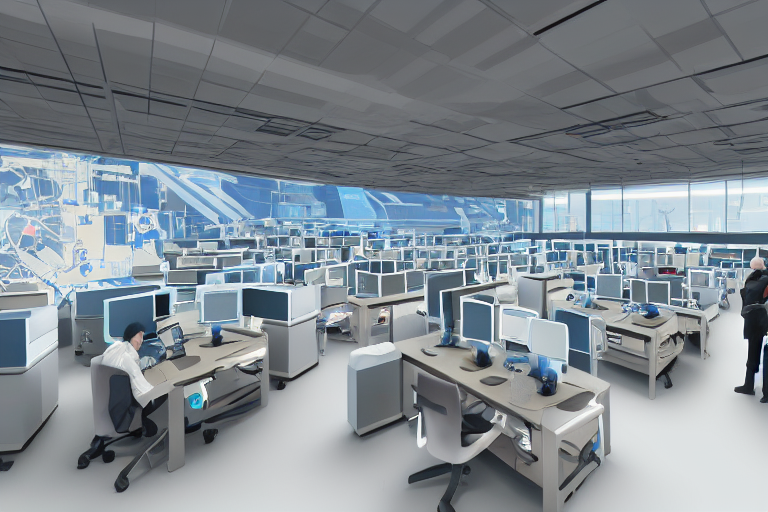

In [ ]:
#prompt = ["Nature, market, flora, fauna, noon, trading , 4k, detailed, trending in artstation, fantasy, vivid colors"]
#prompt = ["A digital illustration of a steampunk computer laboratory with clockwork machines, 4k, detailed, trending in artstation, fantasy vivid colors"]
#prompt = ["Shrek with hes friends in a park sipping some tea, 4k, detailed, vivid colors"]
prompt = ["A painting of a futuristic re-search lab with computers and holorgrams, 4k, detailed, trending in artstation"]
#prompt = ["A teddy bear in a room with lots of toys, 4k, detailed, trending in artstation"]

height = 512
width = 768
num_inference_steps = 100
guidance_scale = 8
generator = torch.manual_seed(42) #steampunk seed (4)
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
(batch_size, unet.in_channels, height // 8, width // 8),
generator=generator,
)

latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

    # Loop
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):

        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents)["prev_sample"]

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0].save(f'/content/drive/MyDrive/stablediff/steampunk.jpeg')
pil_images[0]

# Image Loop

In [ ]:
# Make a folder to store results
!rm -rf /content/drive/MyDrive/stablediff/NatureMarket
!mkdir -p /content/drive/MyDrive/stablediff/CityImages

# Some settings
prompt = ["City landscape from a close POV, 4k, detailed, trending in artstation, vivid colors"]
#prompt = ["an electric sky city on an alien world"]
height = 512                        # default height of Stable Diffusion
width = 768                         # default width of Stable Diffusion
num_inference_steps = 200            # Number of denoising steps
guidance_scale = 8.0                # Scale for classifier-free guidance
generator = torch.manual_seed(23)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

for idx in range(5): #Number of images created
    generator = torch.manual_seed(idx)

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Need to scale to match k

    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents)["prev_sample"]

    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        image = vae.decode(latents).sample

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    pil_images[0].save(f'/content/drive/MyDrive/stablediff/CityImages/CityImage{idx:04}.jpeg')

<ipython-input-8-3760980feaba>:35: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
# Using torchvision.transforms.ToTensor
to_tensor_tfm = tfms.ToTensor()

def pil_to_latent(input_im):
  # Single image -> single latent in a batch (so size 1, 4, 64, 64)
  with torch.no_grad():
    latent = vae.encode(to_tensor_tfm(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
  return 0.18215 * latent.latent_dist.mode() # or .mean or .sample

def latents_to_pil(latents):
  # bath of latents -> list of images
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents)[0]
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

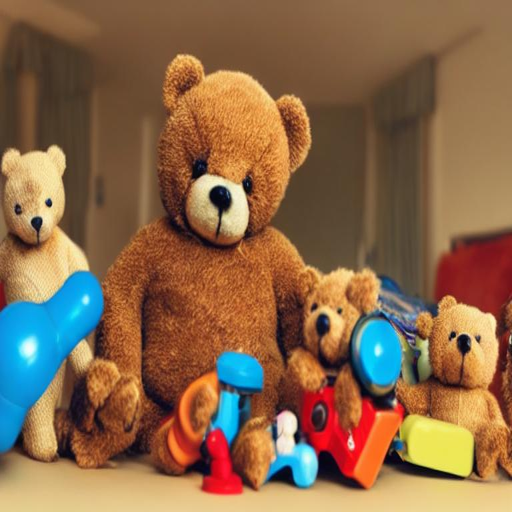

In [ ]:
im = Image.open('/content/drive/MyDrive/stablediff/Images/Teddybear.jpeg').convert('RGB')
im = im.resize((512,512))
encoded = pil_to_latent(im)
im

# Mixed guidance

<ipython-input-15-69e5f5577674>:41: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

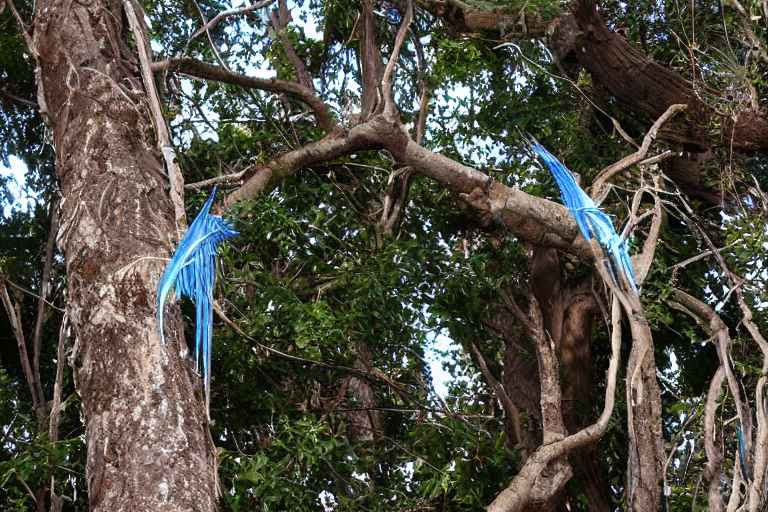

In [ ]:
prompts = ['blue fire', 'reticulated python in a tree']
weights = [0.5,0.5]
height = 512
width = 768
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(5)
batch_size = 1

# Prep text
# Embed both prompts
text_embeddings = []
for i in range(len(prompts)):
    text_input = tokenizer([prompts[i]], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings.append(text_encoder(text_input.input_ids.to(torch_device))[0])

# Take the average
weighted_embeddings = torch.zeros(text_embeddings[0].shape).to(torch_device)

with torch.no_grad():
    for i in range(len(prompts)):
        weighted_embeddings.add_(text_embeddings[i] * weights[i])

text_embeddings = weighted_embeddings

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents)["prev_sample"]

latents_to_pil(latents)[0]

# Denoising Example

In [ ]:
prompt = 'a futuristic city, abandoned and overgrown with plants, dystopia, bathed in sunlight'
height = 512
width = 768
num_inference_steps = 100
guidance_scale = 8
generator = torch.manual_seed(10)
batch_size = 1

# Make a folder to store results
!rm -rf /content/drive/MyDrive/stablediff/denoising2/
!mkdir -p /content/drive/MyDrive/stablediff/denoising2/

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# the uncond. input
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.

    im_input = latents_to_pil(latents)[0]

    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred

    im_t0 = latents_to_pil(latents_x0)[0]
    im_noise = latents_to_pil(sigma * noise_pred)[0]

    # And the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents)["prev_sample"]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (2304, 512))
    im.paste(im_input, (0, 0))
    im.paste(im_noise, (768, 0))
    im.paste(im_t0, (1536, 0))
    im.save(f'/content/drive/MyDrive/stablediff/denoising2/{i:04}.jpg')

<ipython-input-38-d348bb191af7>:32: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/schedulers/scheduling_lms_discrete.py:396: UserWarning: The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
  warnings.warn(
